In [2]:
%matplotlib inline

import imp
import keras.backend
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import time
import keras
import nltk
import re

from keras.datasets import mnist
from keras.models import Model
from keras import optimizers
from nltk.tokenize import word_tokenize
from matplotlib import cm, transforms
from ftfy import fix_encoding

import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [3]:
#!pip install protobuf==3.20.* --user

In [4]:
#!pip install pandas
#!pip install nltk
#!pip install ftfy

In [5]:
SEED=99

# Introduction

In this example, we are going to build a text classifer, inspired by experiments in [Arras et al. (2017a)][arras] and [Arras et al. (2017b)][arras2]. We are going to predict categories from texts, and apply explanation methods provided by iNNvestigate to analyze how words in each text document influence the category prediction.

This analysis is organized as follows: First, we obtain the dataset from the source as well as pretrained word embedding. Secondly, we prepare the dataset for training a neural network. Then, we construct a neural network model, receiving text as input and predicting their categories. Finally, we apply various explanation methods implemented in iNNvestigate to explain decisions from a trained model. The figure below is explanations of a text document for a reviews dataset: red indicates a high relevance score in favour of the prediction, while blue is the opposite.

![][sample]

[arras]: http://www.aclweb.org/anthology/W16-1601
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142
[standford]: https://nlp.stanford.edu/sentiment/
[sample]: https://i.imgur.com/IRQL5oh.png

# Data Preparation

## Downloading The Dataset and Word Embedding

In the first step, we download the dataset from `http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip`.

For an *Unix* environment, one can achieve it by using the command below.

In [6]:
# %%bash
# if [ ! -d "./stanfordSentimentTreebank" ]; then
#     curl -L http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip -O && unzip stanfordSentimentTreebank.zip
# else
#     echo "The data is already there. Skip downloading!!"
# fi

Secondly, as we are going to use an embedding layer as the first layer of our model, embedding weights are required. Fortunately, there are pretrained word embedding available for this dataset, so we do not need to train it from scratch. The pre-trained embedding is provided by L. Arras at [LRP_for_LSTM][leila_lstm_repo]. Therefore, we can simply download the embedding weights and vocabulary files.
```
- https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy
- https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab
```

[leila_lstm_repo]: https://github.com/ArrasL/LRP_for_LSTM/tree/master/model

In [7]:
# %%bash
# if [ ! -e "./stanfordSentimentTreebank/embeddings.npy" ]; then
#     curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/embeddings.npy -o stanfordSentimentTreebank/embeddings.npy &&
#         curl -L https://github.com/ArrasL/LRP_for_LSTM/raw/master/model/vocab -o stanfordSentimentTreebank/vocab
# else
#     echo "The data is already there. Skip downloading!!"
# fi

Lastly, due to an encoding issue in the dataset, we need to install the `ftfy` package for fixing the issue.

## Load Glove Embeddings

In [8]:
#https://www.kaggle.com/datasets/anindya2906/glove6b?resource=download

In [9]:
path_to_glove_file = os.path.join(
    "./stanfordSentimentTreebank/glove_embeddings/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [11]:
vocabs = list(embeddings_index.keys())
total_vocabs = len(vocabs)

# Unknown vocabs are set to <UNK>.
encoder = dict(zip(['<UNK>'] + vocabs, range(0, len(vocabs) +1)))
decoder = dict(zip(encoder.values(), encoder.keys()))

print('We have %d vocabs.' % len(encoder))

We have 400001 vocabs.


In [12]:
encoder

{'<UNK>': 0,
 'the': 1,
 ',': 2,
 '.': 3,
 'of': 4,
 'to': 5,
 'and': 6,
 'in': 7,
 'a': 8,
 '"': 9,
 "'s": 10,
 'for': 11,
 '-': 12,
 'that': 13,
 'on': 14,
 'is': 15,
 'was': 16,
 'said': 17,
 'with': 18,
 'he': 19,
 'as': 20,
 'it': 21,
 'by': 22,
 'at': 23,
 '(': 24,
 ')': 25,
 'from': 26,
 'his': 27,
 "''": 28,
 '``': 29,
 'an': 30,
 'be': 31,
 'has': 32,
 'are': 33,
 'have': 34,
 'but': 35,
 'were': 36,
 'not': 37,
 'this': 38,
 'who': 39,
 'they': 40,
 'had': 41,
 'i': 42,
 'which': 43,
 'will': 44,
 'their': 45,
 ':': 46,
 'or': 47,
 'its': 48,
 'one': 49,
 'after': 50,
 'new': 51,
 'been': 52,
 'also': 53,
 'we': 54,
 'would': 55,
 'two': 56,
 'more': 57,
 "'": 58,
 'first': 59,
 'about': 60,
 'up': 61,
 'when': 62,
 'year': 63,
 'there': 64,
 'all': 65,
 '--': 66,
 'out': 67,
 'she': 68,
 'other': 69,
 'people': 70,
 "n't": 71,
 'her': 72,
 'percent': 73,
 'than': 74,
 'over': 75,
 'into': 76,
 'last': 77,
 'some': 78,
 'government': 79,
 'time': 80,
 '$': 81,
 'you': 82,
 'y

In [13]:
embeddings_list = list(embeddings_index.values())
embeddings_list[0]

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [14]:
embedding = np.zeros((
    len(embeddings_index.values())+1, len(list(embeddings_index.values())[0])
))

embedding

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
for i in range(embedding.shape[0]-1):
    embedding[i+1,:] = embeddings_list[i]

In [16]:
embedding.shape

(400001, 100)

In [17]:
len(embeddings_list)

400000

## Data Preprocessing

In [18]:
DATA_PATH = './stanfordSentimentTreebank'

In [19]:
# with open('%s/vocab' % DATA_PATH, 'rb') as f:
#     vocabs = pickle.load(f) 
#     total_vocabs = len(vocabs) 

#     # Unknown vocabs are set to <UNK>.
#     encoder = dict(zip(['<UNK>'] + vocabs, range(0, len(vocabs) +1)))
#     decoder = dict(zip(encoder.values(), encoder.keys()))
    
#     print('We have %d vocabs.' % len(encoder))

In [20]:
# vocabs

In [21]:
# pretrained_embedding = np.load('%s/embeddings.npy' % DATA_PATH)

# # Unknown vocabs will have embedding weights of zero.
# embedding = np.zeros((pretrained_embedding.shape[0]+1, pretrained_embedding.shape[1]))
# embedding[1:, :] = pretrained_embedding

In [22]:
# pretrained_embedding.shape

## Finance Dataset

### Load Data

In [23]:
df_finance = pd.read_csv("./data/finance_enquiries_v2_small.csv")
df_finance.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,02/07/2020,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I have disputed three ( 3 ) accounts from XXXX...,None,"EQUIFAX, INC.",MI,48066,None,Consent provided,Web,02/07/2020,Closed with explanation,Yes,NaN,3524002
1,04/14/22,"Credit reporting, credit repair services, or o...",Credit reporting,Unable to get your credit report or credit score,Other problem getting your report or credit score,For whatever reason my scores are so much lowe...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",VA,22191,Servicemember,Consent provided,Web,04/14/22,Closed with explanation,Yes,NaN,5447453
2,06/21/21,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Someone tried to apply for some things in my name,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,33523,None,Consent provided,Web,06/21/21,Closed with explanation,Yes,NaN,4477087
3,12/06/2018,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,Opened a new account with BB & T on XX/XX/2018...,Company has responded to the consumer and the ...,BB&T CORPORATION,GA,30339,None,Consent provided,Web,12/06/2018,Closed with explanation,Yes,NaN,3093196
4,08/13/21,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I checked my credit and noticed a account and ...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NJ,7062,None,Consent provided,Web,08/13/21,Closed with explanation,Yes,NaN,4630432


In [24]:
df_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 10000 non-null  object
 1   Product                       10000 non-null  object
 2   Sub-product                   10000 non-null  object
 3   Issue                         10000 non-null  object
 4   Sub-issue                     10000 non-null  object
 5   Consumer complaint narrative  10000 non-null  object
 6   Company public response       10000 non-null  object
 7   Company                       10000 non-null  object
 8   State                         10000 non-null  object
 9   ZIP code                      10000 non-null  object
 10  Tags                          10000 non-null  object
 11  Consumer consent provided?    10000 non-null  object
 12  Submitted via                 10000 non-null  object
 13  Date sent to comp

### Basic Cleaning

In [25]:
finance_data_mapping = {
    "name": {
        "Product": "label",
        "Consumer complaint narrative": "sentence" ,
        "Complaint ID": "phase_id"
    },
    "dtype": {
        "label": "object",
        "sentence": "object",
        "phase_id": "object"
    }
}

In [26]:
df_finance = df_finance[list(finance_data_mapping.get("name").keys())]
df_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       10000 non-null  object
 1   Consumer complaint narrative  10000 non-null  object
 2   Complaint ID                  10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [27]:
df_finance = df_finance.rename(columns=finance_data_mapping.get("name"))
df_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     10000 non-null  object
 1   sentence  10000 non-null  object
 2   phase_id  10000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [28]:
df_finance = df_finance.astype(finance_data_mapping.get("dtype"))
df_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     10000 non-null  object
 1   sentence  10000 non-null  object
 2   phase_id  10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


### Add features (sostr, splitset_label, label_idx)

In [29]:
# Split to 70%, 20%, 10% sets
indexes_ordered = np.arange(len(df_finance))
indexes = np.copy(indexes_ordered)
np.random.seed(SEED)
np.random.shuffle(indexes)

train_ind, test_ind, val_ind = np.split(indexes, [int(.7 * len(df_finance)), int(.9 * len(df_finance))])
print(len(train_ind), len(test_ind), len(val_ind))

df_finance["splitset_label"] = 0

df_finance.loc[train_ind, "splitset_label"] = 1
df_finance.loc[test_ind, "splitset_label"] = 2
df_finance.loc[val_ind, "splitset_label"] = 3
df_finance["splitset_label"].value_counts()

7000 2000 1000


1    7000
2    2000
3    1000
Name: splitset_label, dtype: int64

In [30]:
# add label_idx
cat_mapping = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Debt collection": 1,
    "Mortgage": 2,
    "Credit card or prepaid card": 3,
    "Checking or savings account": 4,
    "Bank account or service": 5
}

df_finance["label_idx"] = df_finance.label.map(cat_mapping)
df_finance.head()

,label,sentence,phase_id,splitset_label,label_idx
0,"Credit reporting, credit repair services, or o...",I have disputed three ( 3 ) accounts from XXXX...,3524002,1,0
1,"Credit reporting, credit repair services, or o...",For whatever reason my scores are so much lowe...,5447453,1,0
2,"Credit reporting, credit repair services, or o...",Someone tried to apply for some things in my name,4477087,1,0
3,Checking or savings account,Opened a new account with BB & T on XX/XX/2018...,3093196,1,4
4,"Credit reporting, credit repair services, or o...",I checked my credit and noticed a account and ...,4630432,2,0


filter the tokenized data by retaining only tokens composed of the following four types of characters: alphabetic, hyphen, dot and apostrophe, and containing at least one alphabetic character. Hereby we aim to remove punctuation, numbers or dates, while keeping abbreviations and compound words. We do not apply any further preprocessing

In [31]:
# Clean sentence to get sostr
def is_match(regex, text):
    pattern = re.compile(regex)
    return pattern.search(text) is not None

keep_pattern = r'[A-Za-z]+|(-)|(\\.)|(\')'
sentence_tokenized_all = []
for i, row in df_finance.iterrows():
    sentence_tokenized = word_tokenize(row["sentence"])
    sentence_tokenized = [x for x in sentence_tokenized if is_match(keep_pattern, x)]
    sentence_tokenized = [re.sub(r'X{2,}', "", x) for x in sentence_tokenized if not is_match(r'X{2,}', x)]
    sentence_tokenized = "|".join(sentence_tokenized)
    sentence_tokenized_all.append(sentence_tokenized)

df_finance["sostr"] = sentence_tokenized_all
print(df_finance["sostr"][0])

I|have|disputed|three|accounts|from|more|than|three|times|with|Equifax|and|These|accounts|are|listed|as|is|reporting|this|inaccurate|information|to|all|three|credit|bureaus|I|have|the|right|to|a|fair|and|accurate|credit|report


In [32]:
NUM_CLASSES=len(df_finance["label_idx"].value_counts())
df_finance["label_idx"].value_counts()

0    5013
1    2194
2    1166
3     870
4     567
5     190
Name: label_idx, dtype: int64

In [33]:
LABEL_MAPPING = dict(zip(['very_negative', 'negative', 'neutral', 'positive', 'very_positive'], range(5)))
LABEL_IDX_TO_NAME = dict(zip(LABEL_MAPPING.values(), LABEL_MAPPING.keys()))

In [34]:
LABEL_MAPPING = cat_mapping
LABEL_MAPPING

{'Credit reporting, credit repair services, or other personal consumer reports': 0,
 'Debt collection': 1,
 'Mortgage': 2,
 'Credit card or prepaid card': 3,
 'Checking or savings account': 4,
 'Bank account or service': 5}

In [35]:
LABEL_IDX_TO_NAME = {
    x[1]:x[0] for x in cat_mapping.items()
}
LABEL_IDX_TO_NAME

{0: 'Credit reporting, credit repair services, or other personal consumer reports',
 1: 'Debt collection',
 2: 'Mortgage',
 3: 'Credit card or prepaid card',
 4: 'Checking or savings account',
 5: 'Bank account or service'}

## Spiting Training, Testing, and Validation Set.

In [43]:
SPLIT_LABEL_MAPPING = {
    'training' : 1,
    'testing': 2,
    'validation': 3
}

MAX_SEQ_LENGTH = 300
EMBEDDING_DIM = embedding.shape[1]

In [44]:
def prepare_dataset(ds):
    filtered_indices = df_finance.splitset_label == SPLIT_LABEL_MAPPING[ds]
    
    texts_in_ds = df_finance[filtered_indices]
    
    xd = np.zeros((len(texts_in_ds), MAX_SEQ_LENGTH, EMBEDDING_DIM))
    y = texts_in_ds.label_idx.values.astype(int)
    
    reviews = []
    for i, sostr in enumerate(texts_in_ds.sostr.values):
        sostr = sostr.lower()
        review = []
        for j, v in enumerate(sostr.split('|')[:MAX_SEQ_LENGTH]):
            if v in encoder:
                e_idx = encoder[v]
            else:
                e_idx = 0
            
            xd[i, j, :] = embedding[e_idx]
            review.append(e_idx)
        reviews.append(review)
        

    return dict(
        x4d=np.expand_dims(xd, axis=1),
        y=y,
        encoded_reviews=reviews
    )
    

DATASETS = dict()

for ds in ['training', 'testing', 'validation']:
    DATASETS[ds] = prepare_dataset(ds)


In [45]:
print('We have %d reviews in the training set, and %d reviews in the testing set' % 
      (len(DATASETS['training']['x4d']), len(DATASETS['testing']['x4d']))
     )

We have 7000 reviews in the training set, and 2000 reviews in the testing set


In [46]:
sample_idx = 1225

print('Review(ID=%d): %s' %
      (sample_idx, ' '.join(map(lambda x: decoder[x], DATASETS['training']['encoded_reviews'][sample_idx]))))

Review(ID=1225): mortgage loan processor <UNK> and closing failed to return seller credit mi <UNK> applied to loan and was not <UNK> loan earnest money check not applied to loan balance of total mortgage borrower brought to closing table in closing cost s in loan document submitted by loan processor the amount of was added into the loan amount docs to be presented from the loan officers calculations copy <UNK> the fraudulent calculations of the closing atty of the up front mip payment which has not been applied in this loan and again was not requested in conventional loan process new american rep stated that the was reflected in loan as other costs which the closing atty and in cooperation with the loan officer overcharged in closing cost s which i opted out to pay but was still included to reflect the other cost s and <UNK> and <UNK> for closing cost s there is no payment in this loan for mip insurance documents presented upon request


# Model Construction

Our classifier is a convolutional neural network, which was experimented in [Arras et al. (2017b)][arras2]. As shown below, the architecture has a convoluationa layer, convolving word embeddings of every two words, followed by a max pooling layer and a softmax layer.

![][arch]

[arch]: https://i.imgur.com/YQDfS5P.png
[arras2]: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0181142

In [47]:
def build_network(input_shape, output_n, activation=None, dense_unit=256, dropout_rate=0.25):
    if activation:
        activation = "relu"

    net = {}
    net["in"] = network_base.input_layer(shape=input_shape)
    net["conv"] = keras.layers.Conv2D(filters=100, kernel_size=(1,2), strides=(1, 1), padding='valid')(net["in"])
    net["pool"] = keras.layers.MaxPooling2D(pool_size=(1, input_shape[2]-1), strides=(1,1))(net["conv"])
    net["out"] = network_base.dense_layer(keras.layers.Flatten()(net["pool"]), units=output_n, activation=activation)
    net["sm_out"] = network_base.softmax(net["out"])


    net.update({
        "input_shape": input_shape,

        "output_n": output_n,
    })
    return net

net = build_network((None, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM), NUM_CLASSES)
model_without_softmax, model_with_softmax = Model(inputs=net['in'], outputs=net['out']), Model(inputs=net['in'], outputs=net['sm_out'])

In [48]:
def to_one_hot(y):
    return keras.utils.to_categorical(y, NUM_CLASSES)

def train_model(model,  batch_size=128, epochs=20):
    
    x_train = DATASETS['training']['x4d']
    y_train = to_one_hot(DATASETS['training']['y'])
    
    x_test = DATASETS['testing']['x4d']
    y_test = to_one_hot(DATASETS['testing']['y'])
    
    x_val = DATASETS['validation']['x4d']
    y_val = to_one_hot(DATASETS['validation']['y'])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(),
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val),
                        shuffle=True
                       )
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [49]:
train_model(model_with_softmax, batch_size=256, epochs=100)

Train on 7000 samples, validate on 1000 samples
Epoch 1/100
7000/7000 [==============================] - 5s 706us/step - loss: 1.5256 - acc: 0.4766 - val_loss: 1.1765 - val_acc: 0.5390
Epoch 2/100
7000/7000 [==============================] - 4s 635us/step - loss: 1.0199 - acc: 0.6334 - val_loss: 0.9154 - val_acc: 0.7010
Epoch 3/100
7000/7000 [==============================] - 4s 577us/step - loss: 0.7863 - acc: 0.7370 - val_loss: 0.7688 - val_acc: 0.7460
Epoch 4/100
7000/7000 [==============================] - 4s 583us/step - loss: 0.6650 - acc: 0.7794 - val_loss: 0.6979 - val_acc: 0.7710
Epoch 5/100
7000/7000 [==============================] - 5s 667us/step - loss: 0.5944 - acc: 0.8064 - val_loss: 0.6456 - val_acc: 0.7810
Epoch 6/100
7000/7000 [==============================] - 5s 694us/step - loss: 0.5479 - acc: 0.8226 - val_loss: 0.6171 - val_acc: 0.7900
Epoch 7/100
7000/7000 [==============================] - 4s 629us/step - loss: 0.5143 - acc: 0.8284 - val_loss: 0.5946 - val_acc: 

7000/7000 [==============================] - 5s 707us/step - loss: 0.0909 - acc: 0.9877 - val_loss: 0.5306 - val_acc: 0.8290
Epoch 61/100
7000/7000 [==============================] - 5s 644us/step - loss: 0.0879 - acc: 0.9881 - val_loss: 0.5363 - val_acc: 0.8220
Epoch 62/100
7000/7000 [==============================] - 5s 724us/step - loss: 0.0849 - acc: 0.9889 - val_loss: 0.5389 - val_acc: 0.8310
Epoch 63/100
7000/7000 [==============================] - 5s 703us/step - loss: 0.0819 - acc: 0.9901 - val_loss: 0.5415 - val_acc: 0.8280
Epoch 64/100
7000/7000 [==============================] - 5s 644us/step - loss: 0.0792 - acc: 0.9910 - val_loss: 0.5425 - val_acc: 0.8300
Epoch 65/100
7000/7000 [==============================] - 5s 658us/step - loss: 0.0765 - acc: 0.9917 - val_loss: 0.5457 - val_acc: 0.8280
Epoch 66/100
7000/7000 [==============================] - 5s 668us/step - loss: 0.0734 - acc: 0.9923 - val_loss: 0.5484 - val_acc: 0.8290
Epoch 67/100
7000/7000 [=======================

In [57]:
model_without_softmax.set_weights(model_with_softmax.get_weights())

# Model Analysis and Visualization

At this stage, we have a trained model and are ready to explain it via **iNNvestigate**'s analyzers.

In [58]:
# Specify methods that you would like to use to explain the model. 
# Please refer to iNNvestigate's documents for available methods.
#methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'pattern.attribution']
methods = ['lrp.z']
kwargs = [{}, {}, {}, {'pattern_type': 'relu'}]

In [59]:
# build an analyzer for each method
analyzers = []

for method, kws in zip(methods, kwargs):
    analyzer = innvestigate.create_analyzer(method, model_without_softmax, **kws)
    analyzer.fit(DATASETS['training']['x4d'], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [60]:
# specify indices of reviews that we want to investigate
test_sample_indices = [97, 175, 1793, 1186, 354, 1043]

test_sample_preds = [None]*len(test_sample_indices)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_indices), len(analyzers), 1, MAX_SEQ_LENGTH])

for i, ridx in enumerate(test_sample_indices):

    x, y = DATASETS['testing']['x4d'][ridx], DATASETS['testing']['y'][ridx]

    t_start = time.time()
    x = x.reshape((1, 1, MAX_SEQ_LENGTH, EMBEDDING_DIM))    

    presm = model_without_softmax.predict_on_batch(x)[0] #forward pass without softmax
    prob = model_with_softmax.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)

        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review %d (%.4fs)'% (ridx, t_elapsed))

Review 97 (0.1262s)
Review 175 (0.0000s)
Review 1793 (0.0000s)
Review 1186 (0.0000s)
Review 354 (0.0000s)
Review 1043 (0.0000s)


## Visualization

To this point, we have all analysis results from iNNvestigate's analyzers, and we are now ready to visualize them in a insightful way. We will use relevance scores from explanation methods to highlight the words in each review. 

We will use  the *blue-white-red (bwr)* color map for this purpose. Hence, words that have a positive score to the prediction are be shaded in *red*, while  negative-contribution or zero-contribution words are then highlighted in *blue*, and *white*, respectively.


In [61]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')


### An Example of  The Visualization
Let assume we have this review `I really love this movie but not in the beginning`. It is predicted as `positive`, and the relevance scores are distributed as follows: 

```
        I 0.20
    really 0.20
      love 0.50
      this 0.10
     movie 0.10
       but 0.10
       not -0.20
        in 0.05
       the 0.05
 beginning 0.08
```

In [62]:
plot_text_heatmap(
    "I really love this movie but not in the beginning".split(' '),
    np.array([0.02, 0.2, 0.5, 0.1, 0.1, 0.1, -0.2, 0.05, 0.00, 0.08])
)

# "love" is shaded with strong red because its relevance score is rather high
# "not" is highlighted in light blue because of its negative score.

Complaint text(id=97): card complaint synchrony bank once again i was faced with deceptive loan practices by synchrony bank when i purchased a guitar on for with a month interest deferred credit card loan through my card that is provided by synchrony bank note that many years ago i had previously cancelled an card before due to the same deceptive loan practices the card statement terms and conditions clearly state you have a deferred interest promotion s expiring on you must pay each deferred interest promotional balance in full by its expiration date to avoid paying accrued interest charges please see the promotional purchase summary section on this statement for further details deferred interest to avoid paying accrued <UNK> charges on any deferred interest promotion s you must pay at least your minimum payment due if any each month and the entire applicable promotional balance by the expiration date eligible card purchases may be billed under one of the following promotions no inter

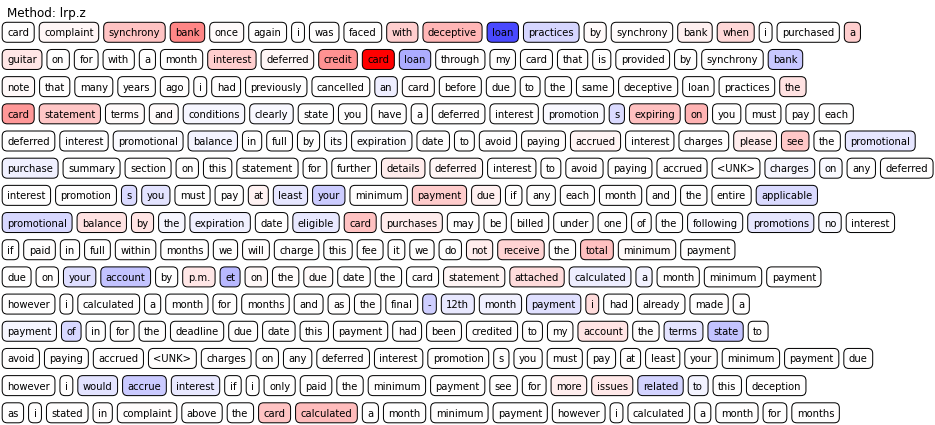

Complaint text(id=175): <UNK> and davidson has placed a collection account on my credit file indicating that i owe a debt that is not mine i have made numerous attempts to get this situation resolved due to the fact that i have no knowledge of the debt owed i have requested verification and validation of the debt owed i have received a copy of a billing stated which is not debt validation there is no signature or contract provided in order to collect on any debt and report any debt by law the collecting party must have this information and provide it to me this has not been done i have attached a copy of the billing statements i was provided this is not validation
Pred class : Debt collection ✓


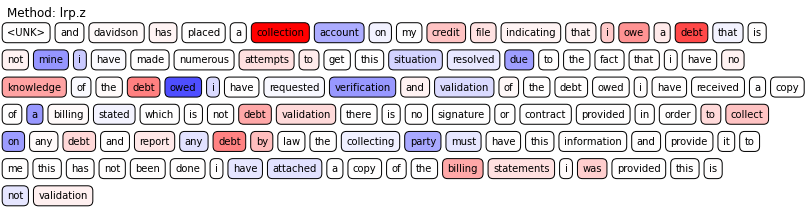

Complaint text(id=1793): i made an online purchase charged to my card my credit score dropped from to for no apparent reason i attempted to <UNK> my transunion credit transunion would not unlock and does not reply to my email on file and locked my account referring me to their online tech support tech support is for computer connectivity problems not unlocking my account or unfreezing i made an additional request filling out all personal information transunion requested to have access to no reply or avail credit utilization no missed payments no new activity current credit card balance with over available credit
Pred class : Credit reporting, credit repair services, or other personal consumer reports ✓


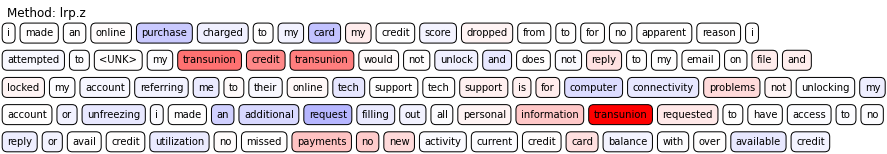

Complaint text(id=1186): so on i call to chime bank because my employer sent me my paycheck to the account account and routing number given to me by chime bank on a pdf but i never receive the payment i call my employer and they tell me the money came back and gave me a check i call chime explain that to them and one more time they send a pdf and tell me next my money was gon na get to my account so i send that to my employer and on my next paycheck was supposed to come but it never arrive till today i call chime on that date and they tell my money should be there by monday i wait until money but on the mean time i call my employer and they send me a copy on the wired transfer i was told by chime they accepted that money on that copy it was saying pending and i told them that and they told me to wait until i was complete and never told they didnt work with that kind of transaction the bank that people send me the money it was from i have and they care i got no money and i dont want to 

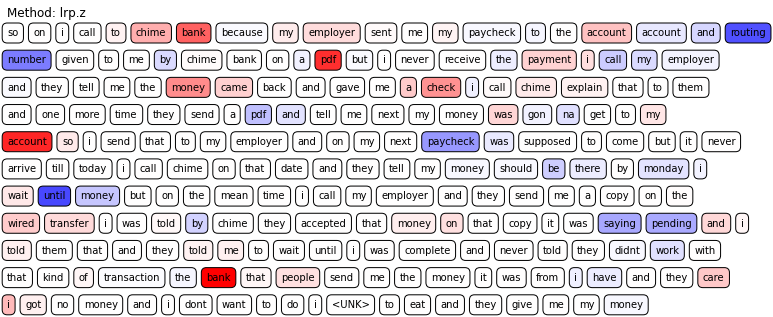

Complaint text(id=354): on i noticed a fraudulent transaction on my bank of america account made on the transaction was displayed as in the amount of at the time i was teaching a class at university where i work as an adjunct professor as soon as my class concluded i immediately logged on to my account i saw that dollars had been charged for watches on my bank of america account that was attached to the address where they were to be delivered was even listed an address i have no association with in florida i immediately contacted customer service informed me that they believed my account had been compromised and suspended the account they also informed me that i would need to contact my bank to report the fraud following this i immediately contacted bank of america and reported the fraud on the funds were temporarily credited to me account on following an investigation i was informed by bank of america that they would not pay the claim i am now being treated as a criminal and forced to

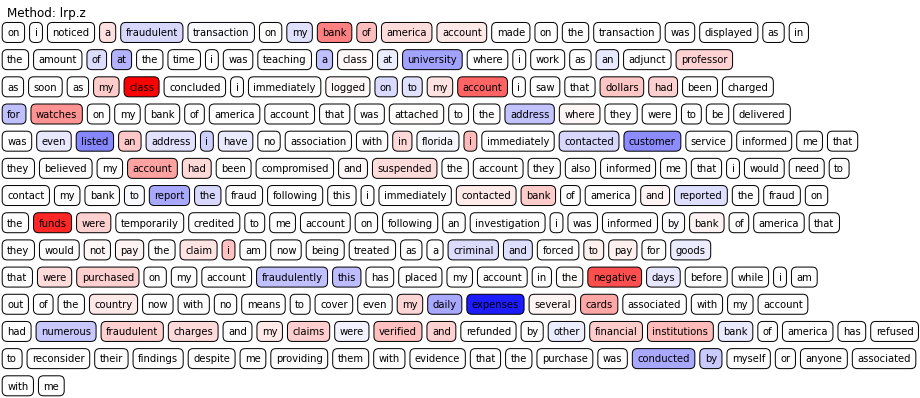

Complaint text(id=1043): this is who is submitting this cfpb complaint myself and to inform you that there is no third party involved in the process i sent letters to experian credit bureau the date of the last letter was on and now we are in the month of still nothing from them that means experian has not complied with the <UNK> act law and continued to report inaccurate information on my credit report please update or remove this account completely from my credit report
Pred class : Credit reporting, credit repair services, or other personal consumer reports ✓


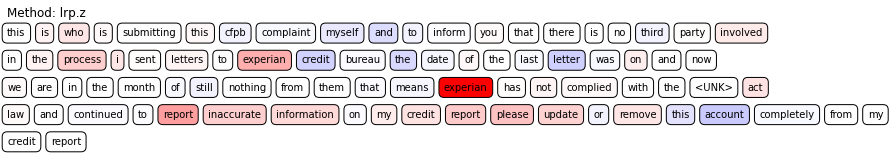

In [63]:
# Traverse over the analysis results and visualize them.
for i, idx in enumerate(test_sample_indices):

    words = [decoder[t] for t in list(DATASETS['testing']['encoded_reviews'][idx])]
    
    print('Complaint text(id=%d): %s' % (idx, ' '.join(words)))
    y_true = DATASETS['testing']['y'][idx]
    y_pred = test_sample_preds[i]

    print("Pred class : %s %s" %
          (LABEL_IDX_TO_NAME[y_pred], '✓' if y_pred == y_true else '✗ (%s)' % LABEL_IDX_TO_NAME[y_true])
         )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()